# Project 1 - Similar Document Searching

## Via Minhash and Locality Sensitive Hashing

### Part IA: Dataset Parsing

#### Write a function that takes a path to a dataset, reads in each article, and returns an array of tuples. 

#### One tuple per article (there is one article per line) 
#### For each article tuples will contain (id, string) where id is the article id and string is the article text formatted as follows:

#### 1) remove all punctuation
#### 2) change all letters to lowercase
#### 3) remove all whitespace so that all words are concatenated

In [1]:
import string

##function to parse a list of strings to output a list of tuples.  each tuple is an id and a formatted string
def parse_data(LinesOfText):
    TheLineTuples = []
    for TheLine in LinesOfText:
        if(len(TheLine) > 0):##split gives an extra row, so make sure there is something there
            ##keep the txxx index separate from the actual text
            TheLineParts = TheLine.split(" ",maxsplit=1)
            ##print(TheLineParts[0])
            ##format each line in TheLines to remove spaces,all to lowercase,and remove punctuation
            MostlyFormattedLine = TheLineParts[1].lower().replace(" ","")
            ##to remove punctuation need tell python that every time it sees punctuation, it should be translated to a none 
            ##the list of punctuation is string.punctuation
            ##the map from punctuation to none is str.maketrans; https://docs.python.org/3/library/stdtypes.html#str.maketrans
            ##the output from str.maketrans is a table suitable for use in str.translate, which acutally carries out the translation
            ##https://docs.python.org/3/library/stdtypes.html#str.translate
            formattedLine = MostlyFormattedLine.translate(str.maketrans(dict.fromkeys(string.punctuation)))
            ##print(formattedLine)
            ##make the tuple
            LineTuple = (TheLineParts[0],formattedLine)
            TheLineTuples.append(LineTuple)
            ##print(LineTuple)
    return TheLineTuples
        

  

In [2]:
#get data to play around with
from six.moves import urllib

DataUrl = "https://raw.githubusercontent.com/chrisjmccormick/MinHash/master/data/articles_100.train"


DataRequest = urllib.request.Request(DataUrl)
with urllib.request.urlopen(DataRequest) as response:
   DataRaw = response.read()
TheLines = str(DataRaw)[2:-1].split('\\n')##snip off the byte stuff and split at carriage returns
MyArticleTuples = parse_data(TheLines)
##print(MyArticleTuples[38])
##print(MyArticleTuples[10])

### Part IB: Document shingles

#### Write a function shingle_document that given a processed article string and a parameter k shards the document as follows:

#### 1) each substring of length $k$ in document is hashed to a 32-bit integer

#### 2) returns a list of the unique 32-bit integers obtained in previous step

In [3]:
from binascii import crc32

##from https://docs.python.org/3/tutorial/datastructures.html#sets...
##A set is an unordered collection with no duplicate elements. 
##Basic uses include membership testing and eliminating duplicate entries. 
##Set objects also support mathematical operations like union, intersection, difference, and symmetric difference.
##make an empty set



###function expects a tuple of length 2(id,article string)
def shingle_document(aTuple):
    ShardSet = set()
    ShardStringSet = set()
    ##specify shingle length
    k=3
    ##take a look at each character of the tuple and keep track of the index of each character
    for CharacterIndex,TheCharacter in enumerate(aTuple[1]):
        ##keep track of id's
        TheArticleId = aTuple[0]
        ##make a string of length k for each character
        TheCrcString = aTuple[1][CharacterIndex:(CharacterIndex+k)]
        ##only process strings of length 3, the last two characters won't have as many permutations
        if(len(TheCrcString) > 2):
            ##just to see
            ShardStringSet.add(TheCrcString)
            ##encode the string to an integer
            CrcHashedItem = crc32(TheCrcString.encode('utf-8'))
            ##add each encoded string to the ShardSet
            ShardSet.add(CrcHashedItem)
    return([ShardSet,ShardStringSet,TheArticleId])

    

### Part IC: Jaccard Similarity

#### Write a function jaccard that given two sharded documents, computes their Jaccard distance

In [4]:
##find ratio of set intersection to their union
def jaccard(Set1,Set2):
    fred = shingle_document(Set1)
    jim = shingle_document(Set2)
    ##intersect
    intersect = fred[0]&jim[0]
    union = fred[0]|jim[0]
    ratio = len(intersect)/len(union)
    return([intersect,union,ratio])


In [5]:
##find ratio of set intersection to their union
##this one is for part 1d
def get_jaccard(ShingledSet1,ShingledSet2):
    ##print(ShingledSet1)
    ##intersect
    intersect = ShingledSet1&ShingledSet2
    union = ShingledSet1|ShingledSet2
    ratio = len(intersect)/len(union)
    return([intersect,union,ratio])

In [6]:
GetJaccard = jaccard(MyArticleTuples[2],MyArticleTuples[4])
print(GetJaccard[2])


0.22275204359673023


### Part ID: Put it all together

#### Input a dataset
#### Output a list of tuples (id1,id2,Jaccard Similarity)

In [7]:
#get data to play around with
from six.moves import urllib

DataUrl = "https://raw.githubusercontent.com/chrisjmccormick/MinHash/master/data/articles_100.train"


DataRequest = urllib.request.Request(DataUrl)
with urllib.request.urlopen(DataRequest) as response:
   DataRaw = response.read()
TheLines = str(DataRaw)[2:-1].split('\\n')##snip off the byte stuff and split at carriage returns
MyArticleTuples = parse_data(TheLines)

##take a look at each character of the tuple and keep track of the index of each character
ParsedShardedArticles = []
for TheFile in MyArticleTuples:
    ##shard each article and keep it in an array of arrays [id,sharded set]
    ShingleResult = shingle_document(TheFile)
    ParsedShardedArticles.append([ShingleResult[2],ShingleResult[0]])
##go through ParsedShardedArticles and perform jaccard similarity for each unique pairing of articles
##put id's and jaccard similarities here
TheOutput = []
for Index,Article in enumerate(ParsedShardedArticles):
    EndIndex = Index + 1
    ##print(ParsedShardedArticles[EndIndex][1])
    while EndIndex <= len(ParsedShardedArticles) - 2:
        GetJaccard = get_jaccard(Article[1],ParsedShardedArticles[EndIndex][1])
        ##print(Article)
        EndIndex = EndIndex + 1
        TheOutput.append((Article[0],ParsedShardedArticles[EndIndex][0],GetJaccard[2]))
print(TheOutput[0:9])
    

[('t980', 't1233', 0.24079528718703977), ('t980', 't1235', 0.22944960686204433), ('t980', 't1297', 0.22230320699708456), ('t980', 't1768', 0.23645680819912152), ('t980', 't1952', 0.22973977695167286), ('t980', 't2023', 0.22375478927203066), ('t980', 't3170', 0.992583436341162), ('t980', 't3171', 0.23984674329501915), ('t980', 't3172', 0.23303834808259588)]


## Part IE: Experiment 0

#### Find the effect of sharding length k on the Jaccard similarity of plagiarism instances versus instances that are not plagiarized. Carry out this experiment using the 1000 document dataset.

First I'll download the 'truth' data for the 1000 document dataset, get the jaccard similarity for each document pair that are known to be cases of plagiarism, and repeat the process for multiple values of k.  Then, I'll get the average similarity for each value of k and store those values somewhere.  I'll repeat the process for document pairs that consist of one document known to be associated with a case of plagiarism and some other document not known to be associated with a case of plagiarism.  I'll get the average similarity for each value of k and store those values with the other k values.  Then, I'll plot k vs average jaccard similarity for each case and inspect the data.

#### Get a nicely formatted list of what the 'truth' document pairs are:

In [8]:

from six.moves import urllib

DataUrl = "https://raw.githubusercontent.com/chrisjmccormick/MinHash/master/data/articles_1000.truth"


DataRequest = urllib.request.Request(DataUrl)
with urllib.request.urlopen(DataRequest) as response:
   DataRaw = response.read()
TheMatchLines = str(DataRaw)[2:-1].split('\\n')##snip off the byte stuff and split at carriage returns
##isolate each document id and keep in a list of lists
DocMatchList = []
for MatchLine in TheMatchLines:
    if(len(MatchLine) > 0):
        MatchLineParts = MatchLine.split(" ")
        TheMatchPair = [MatchLineParts[0],MatchLineParts[1]]
        DocMatchList.append(TheMatchPair)
        
print(DocMatchList)

[['t1088', 't5015'], ['t1297', 't4638'], ['t1768', 't5248'], ['t1952', 't3495'], ['t980', 't2023'], ['t2535', 't8642'], ['t2839', 't9303'], ['t2957', 't7111'], ['t3268', 't7998'], ['t3466', 't7563']]


#### To get a list of (probably) unmatched documents, modify DocMatchList

In [9]:
DocUnmatchList = [['t1088', 't7563'], ['t1297', 't7998'], ['t1768', 't7111'], ['t1952', 't9303'], ['t980', 't8642'], ['t2535', 't2023'], ['t2839', 't3495'], ['t2957', 't5248'], ['t3268', 't4638'], ['t3466', 't5015']]
print(DocUnmatchList)

[['t1088', 't7563'], ['t1297', 't7998'], ['t1768', 't7111'], ['t1952', 't9303'], ['t980', 't8642'], ['t2535', 't2023'], ['t2839', 't3495'], ['t2957', 't5248'], ['t3268', 't4638'], ['t3466', 't5015']]


#### Use parse data to get the 1000 document dataset:

In [10]:
#get data to play around with
from six.moves import urllib

DataUrl = "https://raw.githubusercontent.com/chrisjmccormick/MinHash/master/data/articles_1000.train"


DataRequest = urllib.request.Request(DataUrl)
with urllib.request.urlopen(DataRequest) as response:
   DataRaw = response.read()
TheLines = str(DataRaw)[2:-1].split('\\n')##snip off the byte stuff and split at carriage returns
MyArticleTuples = parse_data(TheLines)

#### Since I'm varying k this time, I'll have to slightly modify shingle_document to allow it to return something different.  Also, I'll only shard documents from the document match list (DocMatchList)

In [11]:
from binascii import crc32

##a list of k values (shingle lengths) to test
kList = range(1,21,1)

###function expects a tuple of length 2(id,article string)
def shingle_document_varyK(aTuple,k):
    ShardSet = set()
    ShardStringSet = set()
    ##take a look at each character of the tuple and keep track of the index of each character
    for CharacterIndex,TheCharacter in enumerate(aTuple[1]):
        ##keep track of id's
        TheArticleId = aTuple[0]
        ##make a string of length k for each character
        TheCrcString = aTuple[1][CharacterIndex:(CharacterIndex+k)]
        ##only process strings of length 3, the last two characters won't have as many permutations
        if(len(TheCrcString) > 0):
            ##just to see
            ShardStringSet.add(TheCrcString)
            ##encode the string to an integer
            CrcHashedItem = crc32(TheCrcString.encode('utf-8'))
            ##add each encoded string to the ShardSet
            ShardSet.add(CrcHashedItem)
    return([ShardSet,TheArticleId,k])

#### Get average JS for each k for matched documents

In [12]:
ParsedShardedTruthArticles = []
JsPerArticlePerK = []
##get the jaccard similarity for each document pair that are known to be cases of plagiarism, 
##and repeat the process for multiple values of k.  
##Then get the average similarity for each value of k and store those values in ParsedShardedTruthArticles
for DocPair in DocMatchList:
    ##print(DocPair)
    for aFile in MyArticleTuples:##look for the articles that correspond to the docpair
        if(aFile[0] == DocPair[0] or aFile[0] == DocPair[1]):
            for k in kList:##when an article is found perform the following for every k in kList
                ShingleResult = shingle_document_varyK(aFile,k)
                ##print(ShingleResult)
                ParsedShardedTruthArticles.append(ShingleResult)
    ##go through and get JS for each article pair for every k
    ##print(len(ParsedShardedTruthArticles))
    for ArticleIndex,ParsedShardedTruthArticle in enumerate(ParsedShardedTruthArticles):
        if(ArticleIndex < 20):##only compare each article to its pair
            Input1 = ParsedShardedTruthArticles[ArticleIndex][0]
            Input2 = ParsedShardedTruthArticles[ArticleIndex + 20][0]
            TheJS = get_jaccard(Input1,Input2)
            JsPerArticlePerK.append([DocPair[0],DocPair[1],TheJS[2],ParsedShardedTruthArticles[ArticleIndex][2]])
        ##PairIndex = PairIndex + 1
##print(JsPerArticlePerK[0:20])
##now average per k using kList
JsPerKinfo = []
for k in kList:
    Sum = 0
    for JsInfo in JsPerArticlePerK:
        if(JsInfo[3] == k):
            Sum = Sum + JsInfo[2]
    TheAvg = Sum/10 ##10 pairs for the 1000 item training set
    JsPerKinfo.append([k,TheAvg])
print(JsPerKinfo)
            

    

[[1, 1.0], [2, 0.996875], [3, 0.9920993227990971], [4, 0.9912357581069238], [5, 0.9901071723000825], [6, 0.988673139158576], [7, 0.9871794871794872], [8, 0.9856459330143539], [9, 0.9841017488076311], [10, 0.9825535289452814], [11, 0.9810126582278482], [12, 0.9794628751974723], [13, 0.9779005524861878], [14, 0.9763406940063091], [15, 0.9747832939322301], [16, 0.9732283464566931], [17, 0.9716758457907162], [18, 0.970125786163522], [19, 0.9685781618224667], [20, 0.9670329670329669]]


In [13]:
#### Get average JS for each k for unmatched documents

In [14]:
ParsedShardedTruthArticlesUn = []
JsPerArticlePerKUn = []
##get the jaccard similarity for each document pair that are known to be cases of plagiarism, 
##and repeat the process for multiple values of k.  
##Then get the average similarity for each value of k and store those values in ParsedShardedTruthArticles
for DocPair in DocUnmatchList:
    ##print(DocPair)
    for aFile in MyArticleTuples:##look for the articles that correspond to the docpair
        ##print(aFile[0])
        if(aFile[0] == DocPair[0] or aFile[0] == DocPair[1]):
            ##print(aFile[0])
            for k in kList:##when an article is found perform the following for every k in kList
                ShingleResult = shingle_document_varyK(aFile,k)
                ##print(ShingleResult)
                ParsedShardedTruthArticlesUn.append(ShingleResult)
    ##go through and get JS for each article pair for every k
    ##print(len(ParsedShardedTruthArticlesUn))
    for ArticleIndex,ParsedShardedTruthArticleUn in enumerate(ParsedShardedTruthArticlesUn):
        if(ArticleIndex < 20):##only compare each article to its pair
            Input1 = ParsedShardedTruthArticlesUn[ArticleIndex][0]
            Input2 = ParsedShardedTruthArticlesUn[ArticleIndex + 20][0]
            TheJS = get_jaccard(Input1,Input2)
            JsPerArticlePerKUn.append([DocPair[0],DocPair[1],TheJS[2],ParsedShardedTruthArticlesUn[ArticleIndex][2]])
        ##PairIndex = PairIndex + 1
##print(JsPerArticlePerK[0:20])
##now average per k using kList
JsPerKinfoUn = []
for k in kList:
    Sum = 0
    for JsInfo in JsPerArticlePerKUn:
        if(JsInfo[3] == k):
            Sum = Sum + JsInfo[2]
    TheAvg = Sum/10 ##10 pairs for the 1000 item training set
    JsPerKinfoUn.append([k,TheAvg])
print(JsPerKinfoUn)

[[1, 0.8529411764705881], [2, 0.6025], [3, 0.25837320574162687], [4, 0.09053685168334849], [5, 0.0372922578029996], [6, 0.01953125], [7, 0.011123897199846565], [8, 0.007229832572298325], [9, 0.004542013626040877], [10, 0.0030200075500188754], [11, 0.0018839487565938209], [12, 0.0007524454477050414], [13, 0.000376081233546446], [14, 0.000376081233546446], [15, 0.000376081233546446], [16, 0.0], [17, 0.0], [18, 0.0], [19, 0.0], [20, 0.0]]


#### now structure the data so that I can cast it to a pandas dataframe to prep for plotting/data visualization

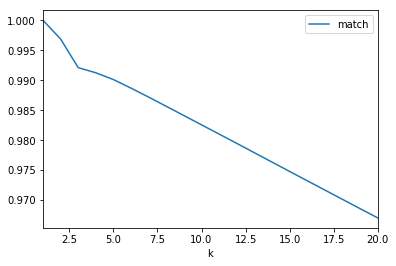

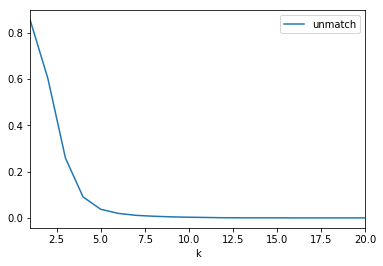

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

JsMatchList = []
JsUnmatchList = []
for Js in JsPerKinfo:
    JsMatchList.append(Js[1])
for Js in JsPerKinfoUn:
    JsUnmatchList.append(Js[1])
##make dataframe
d = {'match': JsMatchList,
     'unmatch': JsUnmatchList,
     'k': kList}
df = pd.DataFrame(d)

df.plot(x='k',y='match')
df.plot(x='k',y='unmatch')
plt.show()

#### Looks like k should be about 3

## Part IIA: Prepare shingles for processing

### Implement a function that takes the shingled documents and returns a list of item-document pairs sorted by items that we’ll use to compute the minhash signature of each document

#### Input is a list of tuples of form (docid, [items])

#### Output is (item, docid) and [list of doc id's]

In [132]:
#get data to play around with
from six.moves import urllib

DataUrl = "https://raw.githubusercontent.com/chrisjmccormick/MinHash/master/data/articles_100.train"


DataRequest = urllib.request.Request(DataUrl)
with urllib.request.urlopen(DataRequest) as response:
   DataRaw = response.read()
TheLines = str(DataRaw)[2:-1].split('\\n')##snip off the byte stuff and split at carriage returns
MyArticleTuples = parse_data(TheLines)

##take a look at each character of the tuple and keep track of the index of each character
ParsedShardedArticles = []
for TheFile in MyArticleTuples:
    ##shard each article and keep it in an array of arrays [id,sharded set]
    ShingleResult = shingle_document(TheFile)
    ParsedShardedArticles.append([ShingleResult[2],ShingleResult[0]])

def invert_shingles(shingled_documents):
    TheInvertedTuples = []
    TheDocIds = []
    for document in shingled_documents:
        TheDocIds.append(document[0])
        for item in document[1]:
            TheInvertedTuples.append((item,document[0]))
    ##before returning the tuples, sort it by item
    SortedInvertedTuples = sorted(TheInvertedTuples)
    return(SortedInvertedTuples,TheDocIds)

theInvert = invert_shingles(ParsedShardedArticles)

In [133]:
print(theInvert[0][0:10])

[(112368, 't3173'), (600180, 't5435'), (600180, 't6521'), (877549, 't3172'), (877549, 't6525'), (877549, 't8474'), (877549, 't9537'), (1235560, 't5439'), (1235560, 't6524'), (1235560, 't8337')]


### Part IIB: Generate hash functions

#### Use the instructor provided make_random_hash_fn function to create a function make_hashes. Given an input num_hashes

#### The function will return a list of hash functions that mimic the random permutation approach used in the Minhash calculation

##### Input is an integer num_hash (the number of hash functions you're trying to create)
##### Output is a list of hash functions created by function generate_random_hash_fn

In [17]:
##instructor provided function

import random

def make_random_hash_fn(p=2**33-355, m=4294967295):
    a = random.randint(1,p-1)
    b = random.randint(0, p-1)
    return lambda x: ((a * x + b) % p) % m

In [120]:
##the function for this part
def make_hashes(num_hashes):
    Count = 0
    hashList = []
    while (Count < num_hashes):
        hash_fn = make_random_hash_fn()
        hashList.append(hash_fn)
        Count = Count + 1
    return(hashList)

In [134]:
x3=make_hashes(10)
print(x3)
x3[0](12345)

[<function make_random_hash_fn.<locals>.<lambda> at 0x0000022B654C3730>, <function make_random_hash_fn.<locals>.<lambda> at 0x0000022B654C31E0>, <function make_random_hash_fn.<locals>.<lambda> at 0x0000022B654C3C80>, <function make_random_hash_fn.<locals>.<lambda> at 0x0000022B654C3488>, <function make_random_hash_fn.<locals>.<lambda> at 0x0000022B654C3950>, <function make_random_hash_fn.<locals>.<lambda> at 0x0000022B654C3D90>, <function make_random_hash_fn.<locals>.<lambda> at 0x0000022B654C3840>, <function make_random_hash_fn.<locals>.<lambda> at 0x0000022B654C37B8>, <function make_random_hash_fn.<locals>.<lambda> at 0x0000022B654C3400>, <function make_random_hash_fn.<locals>.<lambda> at 0x0000022B4F9DCC80>]


2261327207

### Part IIC: Construct the Minhash Signature Matrix

#### Implement a function that builds the Minhash signature matrix

In [136]:
import numpy

def make_minhash_signature(shingled_data, num_hashes):
    inv_index, docids = invert_shingles(shingled_data)
    num_docs = len(docids)
    # initialize the signature matrix with infinity in every entry
    sigmatrix = np.full([num_hashes, num_docs], np.inf)

    # generate hash functions
    hash_funcs = make_hashes(num_hashes)
    ##print(hash_funcs)
    # iterate over each non-zero entry of the characteristic matrix
    for row in inv_index:
        ##print(row)
        ##find the column where this row should point to
        TheColumn = docids.index(row[1])
        ##go through the hash results
        for hashIndex, hashResult in enumerate(hash_funcs):
            ##print([hashIndex,TheColumn])
            if(int(hashResult(row[0])) < sigmatrix[hashIndex,TheColumn]):
                sigmatrix[hashIndex,TheColumn] = hashResult(row[0])
        

    return sigmatrix, docids

In [137]:
matrix,docs = make_minhash_signature(ParsedShardedArticles,2)

In [139]:
print(matrix[0])

[  322786.  3645843.   322786.   322786.    17268.  2343535.   322786.
   322786.  2343535.   322786.   322786.    17268.  2343535.  2343535.
    17268.  2343535.  1522929.    17268.   322786.   322786.   322786.
   322786.   322786.   322786.   322786.   322786.   322786.    17268.
   322786.    17268.   322786.    17268.  3645843.   322786.  2343535.
   322786.    17268.  2343535.    17268.  3124043.  2343535.   322786.
    17268.   322786.   322786.   322786.  2343535.  2343535.    17268.
  2343535.  2343535.    17268.   322786.   322786.    17268.   322786.
   322786.   322786.    17268.   322786.   322786.   322786.    17268.
   322786.   322786.   322786.    17268.    17268.    17268.   322786.
   322786.   322786.    17268.    17268.  2343535.    17268.    17268.
  2343535.  2343535.    17268.    17268.  2343535.    17268.  2343535.
  2343535.  3645843.   322786.  5062640.   322786.  2343535.    17268.
   322786.   322786.   322786.   322786.    17268.   322786.   322786.
  2343

## Part IID: MinHash similarity estimate

#### Write a function that computes the similarity of two documents using the minhash matrix computed above

#### Inputs:
    #### id1, id2: document ids
    #### minhash_sigmat: minhash signature matrix
    #### docids: list of document ids, used to index the columns of the minhash signature matrix

#### Output: Jaccard similarity estimated using minhash

In [ ]:
def minhash_similarity(id1, id2, minhash_sigmat, docids):
  # get column of the similarity matrix for the two documents
  # calculate the fraction of rows where two columns match
  # return this fraction as the minhash similarity estimate